In [25]:
import numpy as np
import torch
import gym
from torch import nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random as rd
import math

In [26]:
seed = 777
np.random.seed(seed)
torch.manual_seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [27]:
class Memory:
    def __init__(self):
        self.batch = []
    
    def clear_the_batch(self):
        self.batch = []

    def add_batch(self, sample: tuple):
        self.batch.append(sample)
    
    def get_batch(self, batch_size):
        state_batch = []
        action_batch = []
        reward_batch = []
        next_state_batch = []
        done_batch = []
        if batch_size > len(self.batch): batch_size = len(self.batch)-1
        for state, action, reward, next_state, done in rd.sample(self.batch,batch_size):
            state_batch.append(state)
            action_batch.append(action)
            reward_batch.append(reward)
            next_state_batch.append(next_state)
            done_batch.append(done)
        return (torch.tensor(state_batch, device=device), torch.stack(action_batch).type(torch.float32), torch.tensor(reward_batch, device=device), torch.tensor(next_state_batch, device=device),torch.tensor(done_batch, device=device))



def t(x): return torch.from_numpy(x).float().to(device)

In [28]:
class Actor(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 2)

        torch.nn.init.kaiming_uniform_(self.fc1.weight)
        torch.nn.init.kaiming_uniform_(self.fc2.weight)
        torch.nn.init.kaiming_uniform_(self.fc3.weight)
        
        self.model = nn.Sequential(
            self.fc1,
            nn.ReLU(),
            self.fc2,
            nn.ReLU(),
            self.fc3,
            nn.Softmax()
        )
    
    def forward(self, X):
        return self.model(X)

In [29]:
class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)
        
        torch.nn.init.kaiming_uniform_(self.fc1.weight)
        torch.nn.init.kaiming_uniform_(self.fc2.weight)
        torch.nn.init.kaiming_uniform_(self.fc3.weight)

        self.model = nn.Sequential(
            self.fc1,
            nn.ReLU(),
            self.fc2,
            nn.ReLU(),
            self.fc3
        )

    
    def forward(self, X):
        return self.model(X)

In [30]:
mu = 0
theta = 0.15
sigma = 0.3

class OU_noise:
    def __init__(self, action_size):
        self.action_dimension = action_size
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

In [31]:
env = gym.make("CartPole-v1")

In [32]:
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
actor = Actor(state_dim).to(device)
buffer = Memory()
critic = Critic(state_dim+2).to(device)
adam_actor = torch.optim.Adam(actor.parameters(), lr=1e-4)
adam_critic = torch.optim.Adam(critic.parameters(), lr=5e-4)

target_actor = Actor(state_dim).to(device)
target_critic = Critic(state_dim+2).to(device)

gamma = 0.99
seta = 0.99
batch_size = 256

In [33]:
actor_state_dict = actor.state_dict()
target_actor.load_state_dict(actor_state_dict)

critic_state_dict = critic.state_dict()
target_critic.load_state_dict(critic_state_dict)

<All keys matched successfully>

In [34]:
is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

def plot_durations(score_list,show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(score_list, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001) 
    
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

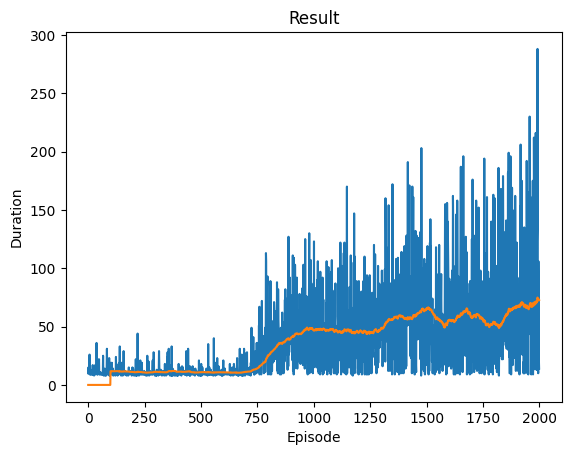

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [35]:
episode_rewards = []

ou_noise = OU_noise(2)

for epoch in range(2000):
    done = False
    total_reward = 0
    state, _ = env.reset()

    while not done:
        
        noise = ou_noise.sample()
        action = (actor(t(state)) + torch.tensor(noise, device=device))

        next_state, reward, done, info, _ = env.step(action.max(0)[1].item())

        buffer.add_batch((state, action, reward, next_state, not(done))) 
        state = next_state
        total_reward += reward
               
    batches = buffer.get_batch(batch_size=batch_size) # state, action, reward, next_state
    
    td_target = (batches[2].view(-1,1) + batches[4].view(-1,1)*gamma*target_critic(torch.cat((batches[3],target_actor(batches[3])), dim=1)))
    
    critic_loss = torch.mean((td_target.detach()-critic(torch.cat((batches[0],batches[1]), dim=1)))**2)
    critic.zero_grad()
    critic_loss.backward(retain_graph=True)
    adam_critic.step()


    actor_loss = - torch.mean(critic(torch.cat((batches[0],batches[1]), dim=-1)))
    actor.zero_grad()
    actor_loss.backward(retain_graph=True)
    adam_actor.step()
    #print(actor_loss)

    actor_state_dict = actor.state_dict()
    target_actor_state_dict = target_actor.state_dict()
    critic_state_dict = critic.state_dict()
    target_critic_state_dict = target_critic.state_dict()

    for key in actor_state_dict:
        actor_state_dict[key] = target_actor_state_dict[key]*seta + actor_state_dict[key]*(1-seta)
    target_actor.load_state_dict(actor_state_dict)

    for key in critic_state_dict:
        critic_state_dict[key] = target_critic_state_dict[key]*seta + critic_state_dict[key]*(1-seta)
    target_critic.load_state_dict(critic_state_dict)
    
    episode_rewards.append(total_reward)
    plot_durations(episode_rewards)

    env.close()

plot_durations(episode_rewards, show_result=True)
plt.ioff()
plt.show()
  

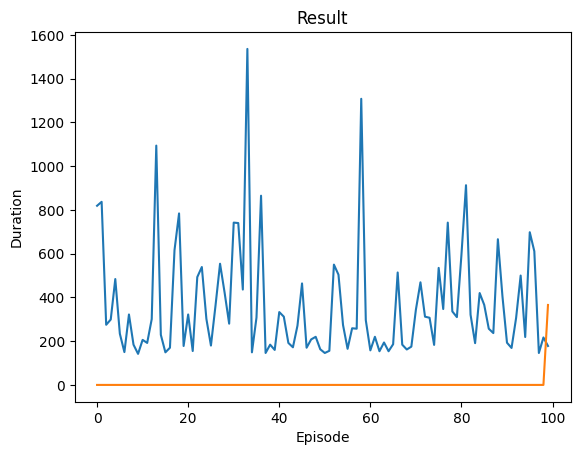

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [40]:
#test
episode_rewards = []

for epoch in range(100):
    done = False
    total_reward = 0
    state, _ = env.reset()

    while not done:
        action = np.argmax((target_actor(t(state)).cpu().detach().numpy()))

        next_state, reward, done, info, _ = env.step(action.item())

        buffer.add_batch((state, [action], reward, next_state)) 
        state = next_state
        total_reward += reward
                  
    episode_rewards.append(total_reward)
    plot_durations(episode_rewards)

    env.close()

plot_durations(episode_rewards, show_result=True)
plt.ioff()
plt.show()